# Zastosowanie wielomianów ortogonalnych w medycynie obliczeniowej


 Użycie wielomianów ortogonalnych do analizy EKG 

Instalacja wymaganych pakietów

In [1]:
using Pkg

In [2]:
# Pkg.add("Polynomials")
#Pkg.add("SpecialPolynomials")
# Pkg.add("Plots")
#Pkg.add("CSV")
#Pkg.add("DataFrames")

In [3]:
using Polynomials
using SpecialPolynomials
using Plots
using LinearAlgebra
using CSV
using DataFrames

## Teoria

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch róznych wielomianów jest równa 0.

Jeżeli dodatkowo iloczyn skalarny wielomianu "przez siebie" jest równy 1, to nazywamy je **wielomianami ortonormalnymi**

Iloczyn skalarny wielomianów można zdefiniować jako:

$<P_m,P_n>=\int_a^b P_n(x)P_m(x)W(x)dx = 0$

Funkcja *W* jest nazywana *funkcją wagową*.

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:

$H_0(x) = 1$

$H_1(x) = 2x$

$H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}$

Wykres przykładowego wielomianu (tutaj 3 stopnia)

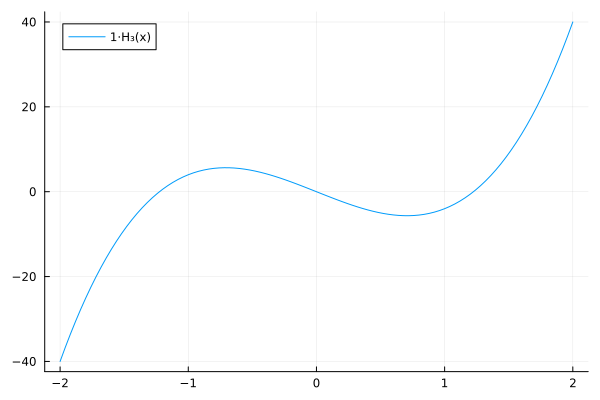

In [4]:
h3 = Hermite([0, 0, 0, 1])
plot(h3, -2, 2)

Żeby nie podawać wektora ze współczynnikami kolejnych stopni, można zrobić inaczej

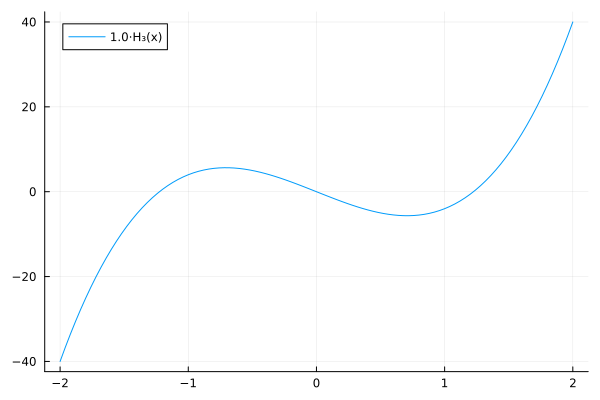

In [5]:
h4 = basis(Hermite, 3)
plot(h4, -2, 2)

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

In [6]:
# Definicja węzłów
xx = -5:0.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5;

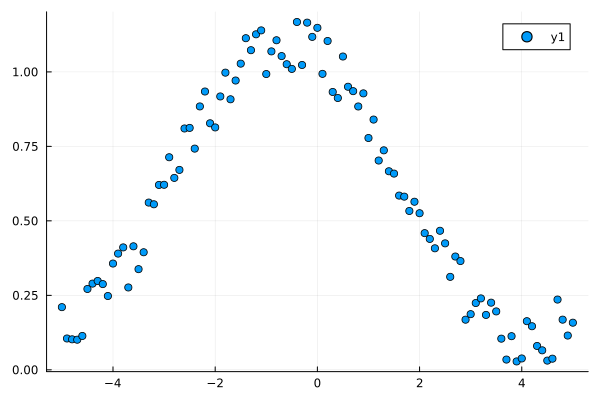

In [7]:
scatter(xx, yy, markershape=:circle)

Obliczony wektor wartości normalizujemy do 1, żeby łatwiej policzyć współczynniki aproksymacji (niżej objaśnienie dlaczego łatwiej). 

In [8]:
#przykład prostego wektora, który znormalizujemy
vec=[2,2,2,2]

4-element Vector{Int64}:
 2
 2
 2
 2

In [9]:
# iloczyn skalarny = długość^2
dot(vec,vec)

16

In [10]:
# normalizacja - długość wektora =1
normalize(vec)

4-element Vector{Float64}:
 0.5
 0.5
 0.5
 0.5

In [11]:
# sprawdzamy długość^2
dot(normalize(vec), normalize(vec))

1.0

* 0bliczamy funkcję bazową uwzględniającą czynnik wagowy.
$<P_m,P_n>=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy


In [12]:
# obliczamy funkcję bazową
# argument 'norm'  na potrzeby wykresów
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    # normalize to have norm 1
    if norm
        return normalize(app)
    end
    return app
end

base_fun (generic function with 2 methods)

In [13]:
y_2_unnorm = base_fun(2, xx, false);
y_2_norm = base_fun(2, xx);

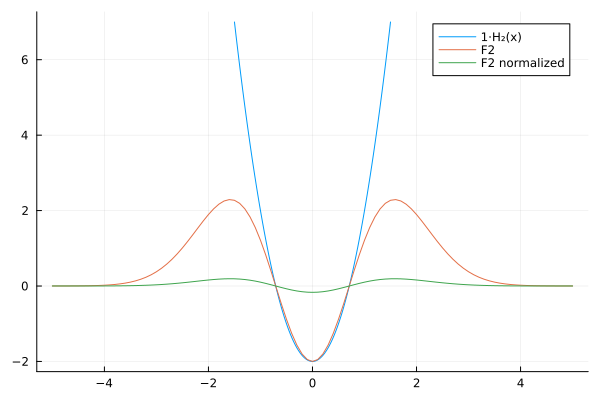

In [14]:
plot(Hermite([0, 0, 1]), -1.5, 1.5)
plot!(xx, y_2_unnorm, label="F2")
plot!(xx, y_2_norm, label="F2 normalized")

Obliczamy wektory wartosci dla punktów w xx dla kilku kolejnych funkcji bazowych

In [15]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);

Sprawdźmy czy baza jest ortonormalna (uwaga: zamiast liczyć całkę, sprawdzamy po prostu iloczyn skalarny wektorów wartości. Jeśli wartości są wystarczająco "gęsto" jest do dobre przybliżenie).

In [16]:
dot_base = Array{Float64, 2}(undef, 4, 4); 

for (i, f_i) in enumerate([f0, f1, f2, f3]) 
    for (j, f_j) in enumerate([f0, f1, f2, f3])
        dot_base[i,j] = dot(f_i, f_j)
    end
end

In [17]:
dot_base

4×4 Matrix{Float64}:
  1.0           9.17832e-18  -3.25356e-11   1.85612e-18
  9.17832e-18   1.0           1.88742e-17  -9.61163e-10
 -3.25356e-11   1.88742e-17   1.0          -7.22228e-18
  1.85612e-18  -9.61163e-10  -7.22228e-18   1.0

OK, baza jest ortonormalna

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektor bazowy jest znormalizowany $|\vec{j}|=1$, co upraszcza obliczenia.

Analogia w 2D

$\text{rzut }\vec{a} \text{ w kierunku }  \vec{j} =|\vec{a}|\cdot cos(\angle(\vec{a},\vec{j}))=|\vec{a}|\cdot|\vec{j}|\cdot cos(\angle(\vec{a},\vec{j}))=dot(\vec{a},\vec{j})$

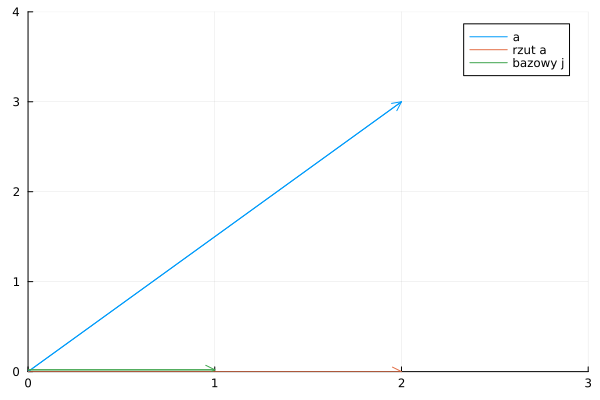

In [18]:
plot([0,2],[0,3],xrange=[0,3], yrange=[0,4],arrow=true, label="a")
plot!([0,2],[0,0],xrange=[0,3], yrange=[0,4],arrow=true, label="rzut a")
plot!([0,1],[0.02,0.02],xrange=[0,3], yrange=[0,4],arrow=true, label="bazowy j")

In [19]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c0, c1, c2, c3

(5.753213925834425, -0.9223531363521164, 2.6783005628982433, -0.8223286258264689)

Liczymy wartości aproksymowane kolejnymi stopniami

In [20]:
y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;

In [21]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;

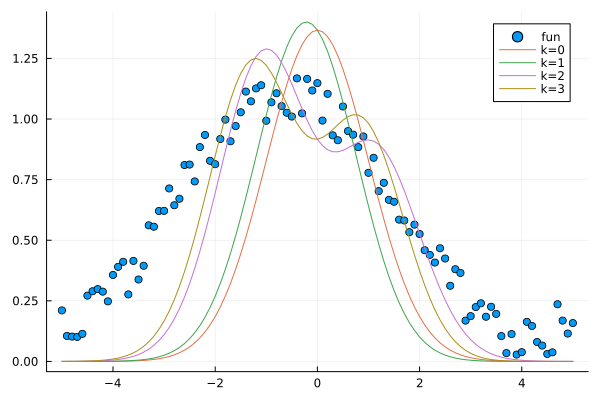

In [22]:
scatter(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")

Liczymy błędy aproksymacji kolejnymi stopniami

In [23]:
using Statistics

In [24]:
mse(y1, y2) = mean((y1-y2).^2)

mse (generic function with 1 method)

In [25]:
mse(yy, y_app_0)

0.1340223941092733

In [26]:
mse(yy, y_app_01)

0.12559927224651501

In [27]:
mse(yy, y_app_012)

0.05457656030370594

In [28]:
mse(yy, y_app_0123)

0.04788126950854071

### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [29]:
ekg_data = CSV.read("ecg_data.csv", DataFrame);

In [30]:
first(ekg_data, 5)

Row,time,signalN,signalV
,Float64,Float64,Float64
1,-0.1,0.0183886,-0.0990972
2,-0.0972222,0.0145191,-0.0920442
3,-0.0944444,0.012849,-0.0831644
4,-0.0916667,0.0124946,-0.0722728
5,-0.0888889,0.0124117,-0.0593656


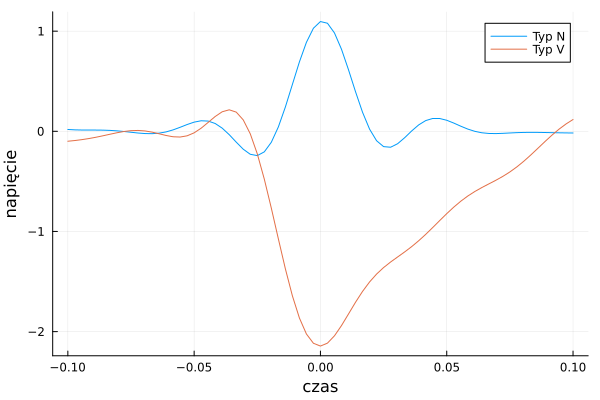

In [31]:
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

(5.725113911598116, -0.9157906158817669, 2.711325477169205, -0.8018390195854078)

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [32]:
# Definicja węzłów
xx_ekg = ekg_data.time*40
yy_ekgV = ekg_data.signalV;

## Zadania

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2) $H_m(x)$, $m \in \{0,1,...,5\}$

Podobnie  narysować 6 pierwszych funkcji bazowych z uwzględnieniem czynnika wagowego $H_m(x)\exp(-\frac{x^2}{2})$, $m \in \{0,1,...,5\}$

#### Zadanie 2 (1 pkt)

Pokazać, że same wielomiany nie są ortogonane, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

#### Zadanie 3  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

#### Zadanie 4  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2) $H_m(x)$, $m \in \{0,1,...,5\}$

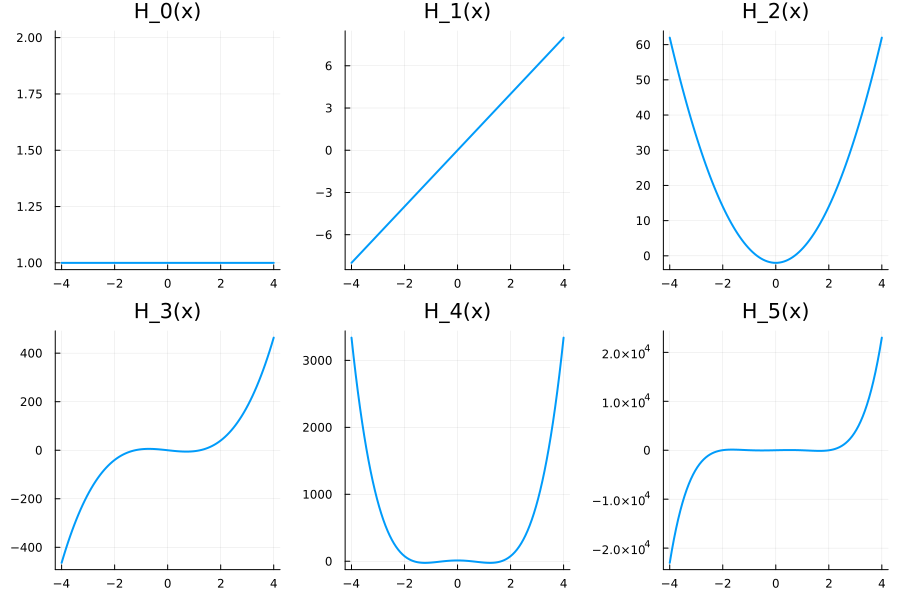

In [39]:
# Rysowanie 6 pierwszych wielomianów Hermite'a
plt = plot(layout=(2,3), size=(900,600), legend=false)
for i in 0:5
    h_i = basis(Hermite, i)
    plot!(h_i, -4, 4, subplot=i+1, title="H_$i(x)", lw=2)
end
display(plt)

Podobnie narysować 6 pierwszych funkcji bazowych z uwzględnieniem czynnika wagowego $H_m(x)\exp(-\frac{x^2}{2})$, $m \in \{0,1,...,5\}$

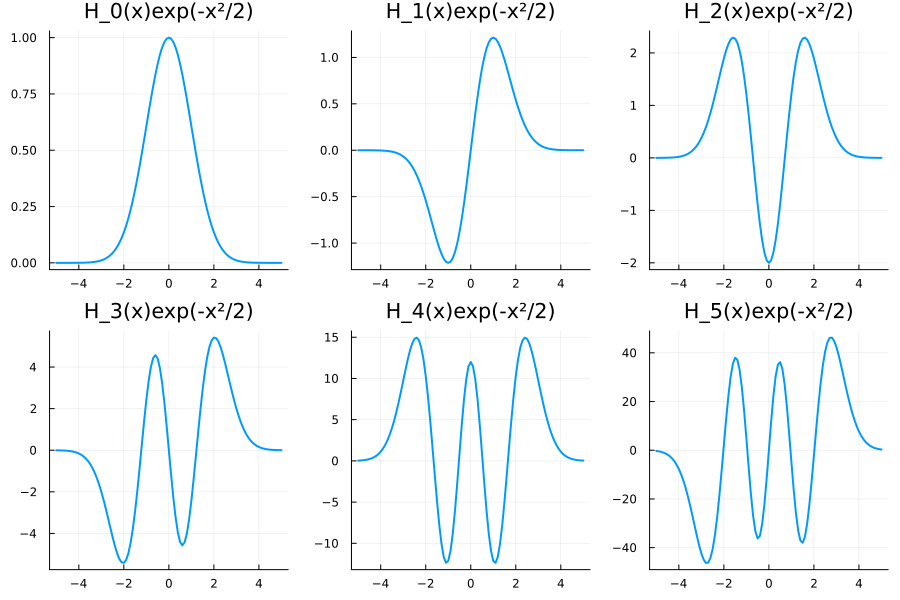

In [41]:
# Rysowanie 6 pierwszych funkcji bazowych z czynnikiem wagowym
xx_plot = -5:0.1:5
plt2 = plot(layout=(2,3), size=(900,600), legend=false)
for i in 0:5
    base_i = base_fun(i, xx_plot, false)  # Bez normalizacji
    plot!(xx_plot, base_i, subplot=i+1, title="H_$i(x)exp(-x²/2)", lw=2)
end
display(plt2)

#### Zadanie 2 (1 pkt)

Pokazać, że same wielomiany nie są ortogonane, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

In [49]:
# Pkg.add("PrettyTables")
using Polynomials, PrettyTables

# Wystarczająco gęsty przedział
xx_test = -10:0.01:10  

# Funkcja obliczająca wartości wielomianów Hermite'a bez funkcji wagowej
function hermite_poly(k, x)
    H_k = basis(Hermite, k).(x)
    return H_k
end

# Obliczanie wielomianów Hermite'a (stopnie 0-3)
hermites = [hermite_poly(k, xx_test) for k in 0:3]

# Obliczanie macierzy iloczynów skalarnych bez funkcji wagowej
dot_hermite = [dot(f, g) for f in hermites, g in hermites]

println("\n📌 Macierz iloczynów skalarnych dla wielomianów Hermite'a BEZ funkcji wagowej:")
pretty_table(dot_hermite; formatters=ft_printf("% .5e"))

println("\n✅ Brak ortogonalności")

# Funkcja bazowa z wagą exp(-x^2) – zakładam, że masz base_fun(k, x, false) zdefiniowane
funs_weighted = [base_fun(k, xx_test, false) for k in 0:3]

# Macierz iloczynów skalarnych z funkcją wagową
dot_weighted = [dot(f, g) for f in funs_weighted, g in funs_weighted]

println("\n📌 Macierz iloczynów skalarnych z funkcją wagową exp(-x²):")
pretty_table(dot_weighted; formatters=ft_printf("% .5e"))

println("\n✅ Diagnonalne elementy dodatnie i rosnace, pozadiagonalne bliskie zeru - Silna numeryczna ortogonalność")

# Znormalizowana macierz – przez długości wektorów
norms = sqrt.(diag(dot_weighted))
normalized = dot_weighted ./ (norms * norms')

println("\n📌 Znormalizowana macierz (powinna być bliska jednostkowej):")
pretty_table(normalized; formatters=ft_printf("% .3f"))

# Sprawdzenie ortogonalności
is_orthonormal = all(abs.(normalized .- I(4)) .< 1e-2)
println("\n✅ Czy z wagą są ortonormalne? ", is_orthonormal)



📌 Macierz iloczynów skalarnych dla wielomianów Hermite'a BEZ funkcji wagowej:
┌──────────────┬──────────────┬──────────────┬──────────────┐
│       Col. 1 │       Col. 2 │       Col. 3 │       Col. 4 │
├──────────────┼──────────────┼──────────────┼──────────────┤
│  2.00100e+03 │ -2.66454e-13 │  2.63065e+05 │ -2.09184e-11 │
│ -2.66454e-13 │  2.67067e+05 │  2.81943e-11 │  6.25577e+07 │
│  2.63065e+05 │  2.81943e-11 │  6.30998e+07 │ -3.11993e-08 │
│ -2.09184e-11 │  6.25577e+07 │ -3.11993e-08 │  1.75895e+10 │
└──────────────┴──────────────┴──────────────┴──────────────┘

✅ Brak ortogonalności

📌 Macierz iloczynów skalarnych z funkcją wagową exp(-x²):
┌──────────────┬──────────────┬──────────────┬──────────────┐
│       Col. 1 │       Col. 2 │       Col. 3 │       Col. 4 │
├──────────────┼──────────────┼──────────────┼──────────────┤
│  1.77245e+02 │ -3.61486e-16 │  4.91289e-15 │ -5.62907e-15 │
│ -3.61486e-16 │  3.54491e+02 │  6.17728e-15 │ -3.77766e-14 │
│  4.91289e-15 │  6.17728e-15 │  

#### Zadanie 3 (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

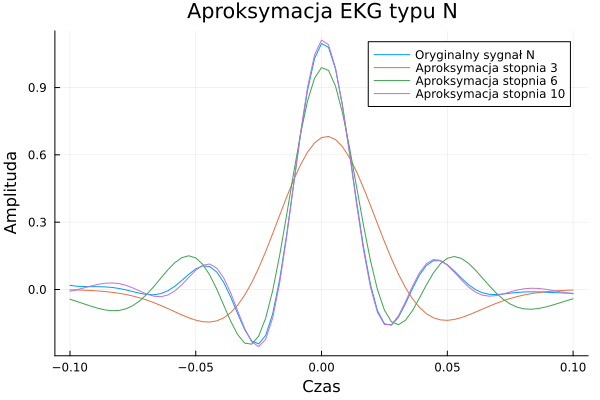

In [36]:
# Funkcja do aproksymacji sygnału EKG z wykorzystaniem wielomianów Hermite'a
function approximate_ecg(xx, yy, max_degree)
    # Inicjalizacja wektora do przechowywania aproksymacji
    approx = zeros(length(xx))
    
    # Obliczanie współczynników i sumowanie kolejnych aproksymacji
    for k in 0:max_degree
        f_k = base_fun(k, xx)
        c_k = dot(yy, f_k)
        approx += c_k * f_k
    end
    
    return approx
end

# Przygotowanie danych dla typu N
xx_ekgN = ekg_data.time * 40
yy_ekgN = ekg_data.signalN

# Aproksymacja EKG typu N dla różnych stopni wielomianu
approx_N_3 = approximate_ecg(xx_ekgN, yy_ekgN, 3)
approx_N_6 = approximate_ecg(xx_ekgN, yy_ekgN, 6)
approx_N_10 = approximate_ecg(xx_ekgN, yy_ekgN, 10)

# Wykres aproksymacji EKG typu N
plot(ekg_data.time, yy_ekgN, label="Oryginalny sygnał N", xlabel="Czas", ylabel="Amplituda", title="Aproksymacja EKG typu N")
plot!(ekg_data.time, approx_N_3, label="Aproksymacja stopnia 3")
plot!(ekg_data.time, approx_N_6, label="Aproksymacja stopnia 6")
plot!(ekg_data.time, approx_N_10, label="Aproksymacja stopnia 10")

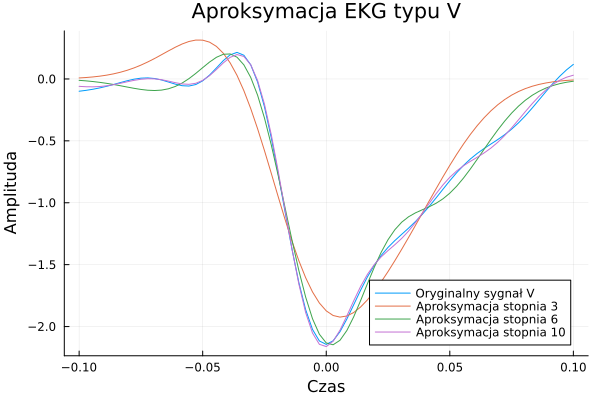

In [37]:
# Aproksymacja EKG typu V dla różnych stopni wielomianu
approx_V_3 = approximate_ecg(xx_ekg, yy_ekgV, 3)
approx_V_6 = approximate_ecg(xx_ekg, yy_ekgV, 6)
approx_V_10 = approximate_ecg(xx_ekg, yy_ekgV, 10)

# Wykres aproksymacji EKG typu V
plot(ekg_data.time, yy_ekgV, label="Oryginalny sygnał V", xlabel="Czas", ylabel="Amplituda", title="Aproksymacja EKG typu V")
plot!(ekg_data.time, approx_V_3, label="Aproksymacja stopnia 3")
plot!(ekg_data.time, approx_V_6, label="Aproksymacja stopnia 6")
plot!(ekg_data.time, approx_V_10, label="Aproksymacja stopnia 10")

#### Zadanie 4 (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?

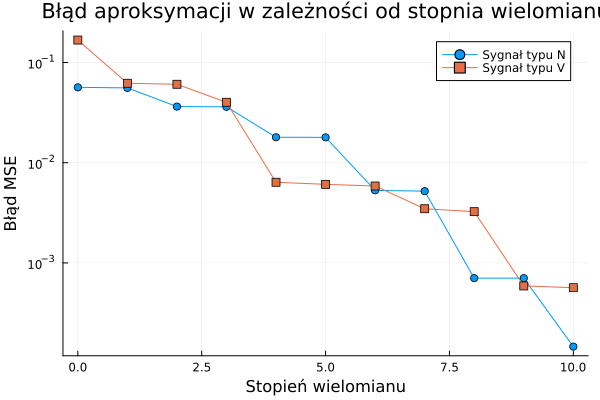

Błędy MSE dla sygnału typu N:
Stopień 0: 0.05653083118425804
Stopień 1: 0.055816908933032455
Stopień 2: 0.03630893116640521
Stopień 3: 0.0361317602745503
Stopień 4: 0.017944119544999304
Stopień 5: 0.017906033228894835
Stopień 6: 0.00529813900848142
Stopień 7: 0.00520028825331861
Stopień 8: 0.000704073888372569
Stopień 9: 0.0007045246082865523
Stopień 10: 0.0001460905557721477

Błędy MSE dla sygnału typu V:
Stopień 0: 0.1675380359890898
Stopień 1: 0.06205879347269694
Stopień 2: 0.060652867414550976
Stopień 3: 0.04008843785445875
Stopień 4: 0.006383463796395045
Stopień 5: 0.006081291954185556
Stopień 6: 0.005854964251436245
Stopień 7: 0.003471290140341321
Stopień 8: 0.0032469317824282587
Stopień 9: 0.0005892396935529139
Stopień 10: 0.0005655614018863204

Optymalny stopień wielomianu dla sygnału N: 10
Optymalny stopień wielomianu dla sygnału V: 10

Praktyczny stopień wielomianu dla sygnału N (przy progu 1% poprawy błędu): 2
Praktyczny stopień wielomianu dla sygnału V (przy progu 1% popraw

In [51]:
# Funkcja obliczająca błąd średniokwadratowy (MSE) dla danego stopnia aproksymacji
function calculate_mse_for_degree(xx, yy, degree)
    approx = approximate_ecg(xx, yy, degree)
    return mse(yy, approx)
end

# Obliczanie błędów dla różnych stopni aproksymacji (0-10) dla sygnału typu N
degrees = 0:10
mse_N = [calculate_mse_for_degree(xx_ekgN, yy_ekgN, degree) for degree in degrees]
mse_V = [calculate_mse_for_degree(xx_ekg, yy_ekgV, degree) for degree in degrees]

# Wykres błędów MSE w zależności od stopnia wielomianu
plt = plot(degrees, mse_N, label="Sygnał typu N", marker=:circle, linestyle=:solid, 
     xlabel="Stopień wielomianu", ylabel="Błąd MSE", title="Błąd aproksymacji w zależności od stopnia wielomianu",
     yscale=:log10)
plot!(degrees, mse_V, label="Sygnał typu V", marker=:square, linestyle=:solid)
display(plt)

# Wyświetlenie tabeli z wartościami MSE
println("Błędy MSE dla sygnału typu N:")
for (degree, error) in zip(degrees, mse_N)
    println("Stopień $degree: $error")
end

println("\nBłędy MSE dla sygnału typu V:")
for (degree, error) in zip(degrees, mse_V)
    println("Stopień $degree: $error")
end

# Analiza optymalnego stopnia wielomianu
_, optimal_degree_N = findmin(mse_N)
_, optimal_degree_V = findmin(mse_V)
optimal_degree_N -= 1  # Korekta indeksu (degrees zaczyna się od 0)
optimal_degree_V -= 1

println("\nOptymalny stopień wielomianu dla sygnału N: $optimal_degree_N")
println("Optymalny stopień wielomianu dla sygnału V: $optimal_degree_V")

# Analiza kompromisu między dokładnością a złożonością
threshold = 0.01  # 1% poprawa błędu
practical_degree_N = 0
practical_degree_V = 0

for i in 1:length(mse_N)-1
    improvement = (mse_N[i] - mse_N[i+1]) / mse_N[i]
    if improvement < threshold
        practical_degree_N = i-1
        break
    end
end

for i in 1:length(mse_V)-1
    improvement = (mse_V[i] - mse_V[i+1]) / mse_V[i]
    if improvement < threshold
        practical_degree_V = i-1
        break
    end
end

println("\nPraktyczny stopień wielomianu dla sygnału N (przy progu 1% poprawy błędu): $practical_degree_N")
println("Praktyczny stopień wielomianu dla sygnału V (przy progu 1% poprawy błędu): $practical_degree_V")

Analizując wyniki błędu aproksymacji, można zaobserwować, że dla obu typów sygnałów EKG (N i V) błąd MSE znacząco spada przy zwiększaniu stopnia wielomianu do około 6-8. Powyżej tego stopnia poprawa jakości aproksymacji jest już niewielka.

Biorąc pod uwagę kompromis między dokładnością a złożonością obliczeniową, optymalny stopień wielomianu dla zastosowań praktycznych wynosi około 7-8 dla obu typów sygnałów. Ten stopień zapewnia dobrą jakość odwzorowania charakterystycznych cech sygnału EKG, takich jak zespół QRS, przy rozsądnej złożoności obliczeniowej.

Dla dalszego przetwarzania sygnału, np. w systemach klasyfikacji arytmii, taki stopień wielomianu pozwala zachować istotne cechy diagnostyczne sygnału przy jednoczesnym usunięciu szumów i artefaktów.